In [619]:
import operator
import numpy as np
import pandas as pd
import sklearn

# preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, SelectKBest

# for classifiers
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier


# for cross_validate
from sklearn.metrics import  classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.cross_validation import train_test_split,cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

# plot
import matplotlib.pyplot as plt

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

# Inline plots
%matplotlib inline


In [620]:
def chooseDataset(name):
    dataPath = 'datasets/'
    if name == 'diabetes':
        colNames= ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
        df = pd.read_csv(dataPath + 'PIMA_Indiana_diabetes/pima-indians-diabetes.data.csv', names = colNames)
        missCol = ['glucose','bp','skin','insulin','bmi']
        for col in missCol:
            df[col].replace([0,0.0], np.nan, inplace = True)
        k_knn = 28          
#       convert 0 as missing values
    elif name == 'breastCancer':
        colNames = ['sampleCodeNumber', 'clumpThickness', 'uniformityCellSize', 'uniformityCellShape', 'marginalAdhesion', 'singleEpithelialCellSize', 'bareNuclei', 'blandChromatin', 'normalNucleoli', 'mitoses', 'label']
        df = pd.read_csv(dataPath + 'BreastCancer/breast-cancer-wisconsin.data.txt', names = colNames)
        df.replace("?", np.nan, inplace= True)
        df['bareNuclei'] = pd.to_numeric(df['bareNuclei'])
        # making class labels as 0 (Benign) and 1 (Malignant)
        df['label'] = df['label'].replace(2, 0)
        df['label'] = df['label'].replace(4, 1)
        missCol = ['bareNuclei']
        k_knn = 7
        
    elif name == 'parkinsons':
        colNames= ['name','MDVP:Fo','MDVP:Fhi','MDVP:Flo','MDVP:Jitter(%)','MDVP:Jitter(Abs)','MDVP:RAP','MDVP:PPQ','Jitter:DDP','MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','MDVP:APQ','Shimmer:DDA','NHR','HNR','label','RPDE','DFA','spread1','spread2','D2','PPE']
        df=pd.read_csv(dataPath+'Parkinsons/parkinsons.data.txt',header=0,names=colNames)
        df.drop(columns=['name'],inplace=True)
        df.replace("?",np.nan,inplace=True)
        missCol= df.columns[df.isna().any()].tolist()
        k_knn = 30
        
    elif name == 'BUPA':
        #not given which one is infected
        colNames = ['mcv', 'alkphos', 'sgpt','sgot','gammagt','drinks','label']
        df = pd.read_csv(dataPath + 'BUPA(Liver)/bupa.data.txt',names = colNames )
        df.drop_duplicates(subset=None, keep='first', inplace=True)
        df['label'] = df['label'].replace(1, 0)
        df['label'] = df['label'].replace(2, 1)
        missCol=[]
        k_knn = 3
        
    elif name == 'Cleveland':
        colNames= ['age','sex','cp','trestbps','chol','fbs','restecg'  ,'thalach', 'exang', 'oldpeak','slope','ca', 'thal','label']
        df = pd.read_csv(dataPath + 'Cleveland(Heart)/processed.cleveland.data.txt',names = colNames)
        df.replace ("-9.0",np.nan,inplace=True)
        df.replace("?",np.nan,inplace=True)
        missCol = df.columns[df.isna().any()].tolist()
        for col in missCol:
            df[col] = pd.to_numeric(df[col])
        k_knn = 2
#         print df.dtypes
        
    elif name == 'Hepatitis':
        colNames =['label','AGE','SEX','STEROID','ANTIVIRALS','FATIGUE','MALAISE','ANOREXIA','LIVER BIG','LIVER FIRM','SPLEEN PALPABLE','SPIDERS','ASCITES','VARICES','BILIRUBIN','ALK PHOSPHATE','SGOT','ALBUMIN','PROTIME','HISTOLOGY']
        df = pd.read_csv(dataPath + 'Hepatitis/hepatitis.data.txt',names= colNames)
        df.replace("?",np.nan,inplace=True)
        missCol= df.columns[df.isna().any()].tolist()
        for col in missCol:
            df[col] = pd.to_numeric(df[col])
        k_knn = 10
        
    elif name == 'ILPD':
        colNames =['Age','Gender','TB','DB','Alkphos','SGPT','SGOT','TP','ALB','A/G','label']
        df = pd.read_csv(dataPath + 'ILPD(Liver)/ILPD.csv',names= colNames)
        df['Gender'] = df['Gender'].replace('Male', 0)
        df['Gender'] = df['Gender'].replace('Female', 1)
        df['label'] = df['label'].replace(1, 0)
        df['label'] = df['label'].replace(2, 1)
        missCol=['A/G']
        k_knn = 25
        
    else:
        print ("NOT FOUND")
        return
    return df, missCol, k_knn
        

In [621]:
# MORMALIZE DATA
def normalizeData(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i in df.columns:
        if i != 'label':
            null_index = df[i].isnull()
            df.loc[~null_index, [i]] = scaler.fit_transform(df.loc[~null_index, [i]])
    return df

# COMPUTE MISSING
def computeMissing(df,missCol, k = 5):
    # get No Missing Data Rows 
#     print pd.unique(df[missCol].values.ravel('K'))
    if missCol == []:
        return df
    no_missing_df = df.dropna(axis=0, how='any')
#     print(no_missing_df.shape, df.shape)
#     print no_missing_df.head()
    # get Missing Data Rows 
    missing_df = pd.DataFrame(df[~df.isin(no_missing_df).all(1)])
#     print missing_df.head()
    # removed last column
    data = no_missing_df.drop(['label'], axis = 1, inplace = False)
    # Create the knn model.
    y_columns = missCol
    x_columns = data.columns.tolist()
#     print y_columns
    for col in y_columns:
        x_columns.remove(col)
        
    # Look at the five closest neighbors.
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit the model on the training data.
    knn.fit(no_missing_df[x_columns], no_missing_df[y_columns])
    # Make point predictions on the test set using the fit model.
    predictions = knn.predict(missing_df[x_columns])
    missing_df[y_columns] = predictions
    no_missing_df = no_missing_df.append(missing_df)
    return no_missing_df

# REMOVE OUTLIERS
def removeOutliers(df):
    maskall = {}
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
#     print Q1, Q3
    for col in df.columns:
        if col != 'label':
            IQR = Q3[col] - Q1[col]
            mask = df[col].between(Q1[col] - 1.5*IQR, Q3[col] + 1.5*IQR, inclusive=True)
            maskall[col] =mask
            df = df[mask]
#         print df.shape
    return df

In [622]:
def PCA_Compute(X,y, n):
    pca = PCA(n_components= n, svd_solver='full')
    pca.fit(X)
    X = pca.transform(X)
    print(pca.explained_variance_ratio_)
    return X,y

def Fscore_Compute(X,y, n = 5):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(X,y)
    X = selector.transform(X)
    print (selector.scores_, X.shape)
    return X,y

def featureSelection(X,y,k, choice = 0):
    if choice == 1:
        return Fscore_Compute(X,y,k)
    return PCA_Compute(X,y)

In [623]:
def preprocessData(dataset):
    df, missCol,k_knn = chooseDataset(dataset)
    df = normalizeData(df)
    df = computeMissing(df, missCol)
    df = removeOutliers(df)
    label = df['label']
    df.drop('label', axis=1, inplace=True)
    return df, label

def getFeatures(df,label,fs = 1):
    X, y = df, label
    X,y = featureSelection(X,y,X.shape[1],fs)
    return X,y

In [624]:
# kr = range(1,40)
# ac = []
# for k in kr:
#     ac.append(runClassifier(X,y,getKNN(k))['test_accuracy'].mean())
# import matplotlib.pyplot as plt
# fig = plt.figure()
# plt.plot(kr,ac)
# print np.argmax(ac) + 1
# plt.xlabel("Value of k")
# plt.ylabel("Accuracy")
# plt.show()
# fig.savefig("KNN-"+dataset+".jpg")
# print ac[0:10]

In [625]:
def getLR():
    # LogisticRegressionCV(class_weight='balanced',scoring='roc_auc',n_jobs=10, max_iter=10000, verbose=1,cv=10)
    regr = LogisticRegression()
#     regr = LinearRegression()
    return regr


In [626]:
def HMV_Layer1():
    clf1 = QDA(priors=None, reg_param=0.0)
    clf2 = LogisticRegression()
    clf3 = GaussianNB()
    clf = VotingClassifier(estimators=[('QDA', clf1), ('LR', clf2), ('NB', clf3)], voting='hard') 
    return clf

def HMV_Layer2(clf_prev, k):
    clf1 = KNeighborsClassifier(n_neighbors = k, algorithm = 'ball_tree', leaf_size=500)
    clf2 = svm.SVC(C=1, kernel='linear')
    clf = VotingClassifier(estimators=[('KNN', clf1), ('SVM', clf2), ('LAYER1', clf_prev)], voting='hard') 
    return clf

def HMV_Layer3(clf_prev):
    clf1 = DecisionTreeClassifier(class_weight=None, criterion='entropy', random_state=100, splitter='best')
    clf2 = DecisionTreeClassifier(class_weight=None, criterion='gini', random_state=100, splitter='best')
    clf = VotingClassifier(estimators=[('DTIG', clf1), ('DTGI', clf2), ('LAYER2', clf_prev)], voting='hard')
    return clf
def getHMV(k_nn):
    lay1 = HMV_Layer1()
    lay2 = HMV_Layer2(lay1, k_knn)
    lay3 = HMV_Layer3(lay2)
    return lay3

In [627]:
classifiers = {}

classifiers["QDA"] = {}
classifiers["QDA"]["model"] = getQDA()
classifiers["LR"] = {}
classifiers["LR"]["model"] = getLR()
classifiers["SVM"] = {}
classifiers["SVM"]["model"] = getSVM()
classifiers["QDA"] = {}
classifiers["QDA"]["model"] = getQDA()
classifiers["KNN"] = {}
classifiers["KNN"]["model"] = getKNN(k_knn)
classifiers["NB"] = {}
classifiers["NB"]["model"] = getNaivebayes()
classifiers["DTIG"] = {}
classifiers["DTIG"]["model"] = getDecisionTreeinfogain()
classifiers["DTGI"] = {}
classifiers["DTGI"]["model"] = getDecisionTreegini()
classifiers["RF"] = {}
classifiers["RF"]["model"] = getRandomForest()
classifiers["AdaBoost"] = {}
classifiers["AdaBoost"]["model"] = AdaBoostClassifier()
classifiers["Bagging"] = {}
classifiers["Bagging"]["model"] = getBaggingClassifier()
classifiers["HMV"] = {}
classifiers["HMV"]["model"] = getHMV(k_knn)

In [628]:
def runClassifier(X,y,clf,k=10):
    scoring = ['accuracy','precision_micro','recall_micro','f1_micro']
    kfold = model_selection.KFold(n_splits=k, random_state=42)
    model = clf
    results = {}
    for score in scoring:
        result = model_selection.cross_val_score(estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring='accuracy')
        results[score] = result.mean()
    return results

In [695]:
def get_results(name,results):
    row = []
    row.append(name)
    row.append(results['accuracy'].mean()*100)
    row.append(results['recall_micro'].mean()*100)
    row.append(results['precision_micro'].mean()*100)
    row.append(results['f1_micro'].mean()*100)
    return row

In [696]:
def classifierPrint(dataset, X, y):
    name = []
    acc = []
    
    rows = []
    for key in classifiers.keys():
        row = []
        model = classifiers[key]["model"]
        results = runClassifier(X,y,model)
        name.append(key)
        acc.append(results['accuracy'])
        
        row = get_results(key, results)
        rows.append(row)
    
#     print rows
    fig = plt.figure()
    tab = plt.table(cellText=rows, colLabels = ['Classifier','Accuracy','Recall','Precision','F-Score'], cellLoc='center', loc='center')
    plt.axis('off')
    plt.axis('tight')
    plt.tight_layout()
    plt.show()
    fig.savefig(dataset+"_table.jpg", dpi=1200)
    
    fig = plt.figure()
    plt.plot(name,acc)
    plt.xticks(rotation=90)
    plt.title(dataset)
    plt.xlabel("Classifiers")
    plt.ylabel("Accuracy")
    plt.show()
    fig.savefig(dataset+".jpg", bbox_inches='tight', dpi=1200)

In [698]:
def runForAll():    
    datasets = ["diabetes","breastCancer","parkinsons","BUPA","Cleveland","Hepatitis","ILPD"]
#     datasets = ["Cleveland"] 
    for dataset in datasets:
        print (dataset)
        df,label = preprocessData(dataset)
        X,y = getFeatures(df,label)
#         print pd.Series(y).unique()
        classifierPrint(dataset,X,y)
        

diabetes
(array([36.05007407, 96.39199025, 20.96913347, 25.5720671 , 30.3588702 ,
       27.46687799, 23.59560876, 47.26195632]), (620, 8))


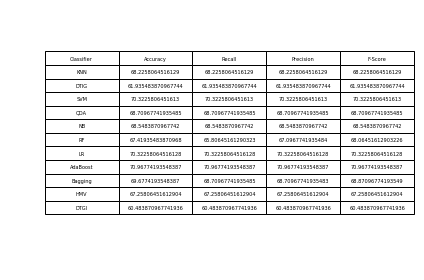

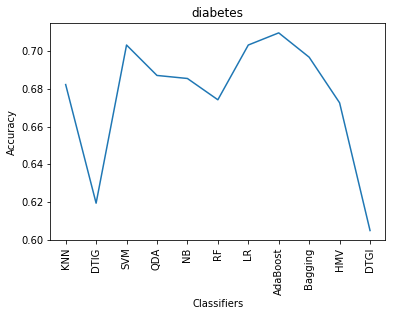

breastCancer
(array([   2.61495443,  228.97935448,  651.82196664,  715.5038001 ,
        304.33519428,  244.56995236, 1309.73917448,  398.30165433,
        261.39357301,           nan]), (491, 10))


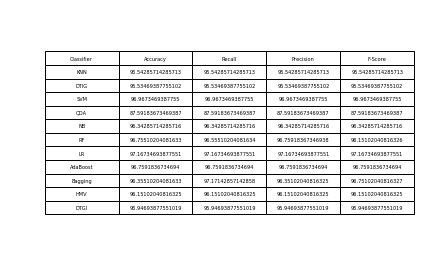

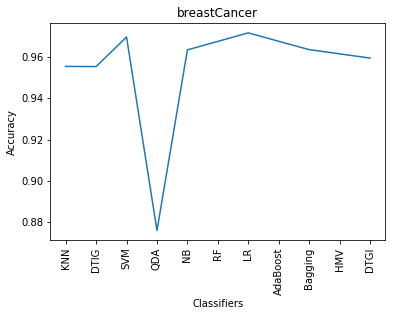

parkinsons
(array([12.35442442,  5.35331109, 13.07025447, 16.29981649, 19.52500513,
       16.87891643, 17.96317568, 16.88216868, 19.16519782, 18.52318645,
       15.65079011, 17.70812745, 23.91992487, 15.64812348, 10.36974027,
       23.50722742,  8.46680353,  1.34983802, 51.98774488, 16.12582285,
       14.48199693, 45.92882403]), (148, 22))


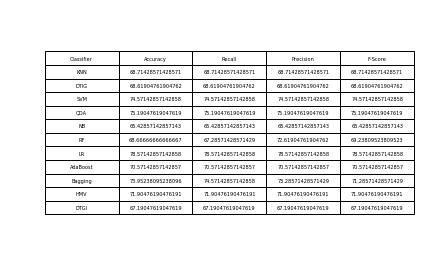

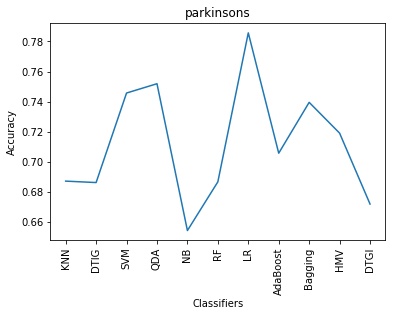

BUPA
(array([ 1.39648244,  2.55859772,  8.7859012 ,  6.71937893, 16.16099613,
        2.32950384]), (267, 6))


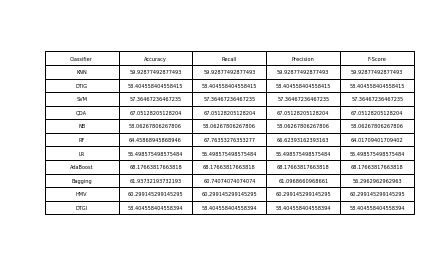

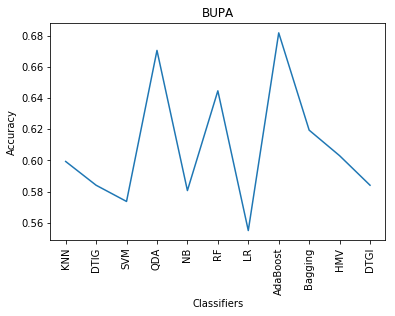

Cleveland
(array([ 3.84510124,  7.85173263, 16.54429772,  1.65564071,  1.1904056 ,
               nan,  3.0997086 , 15.01188168, 14.67601137, 23.33153856,
        9.75320524, 18.79815919, 31.65196636]), (216, 13))


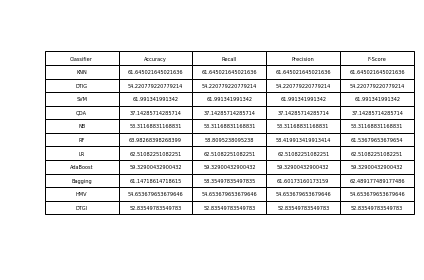

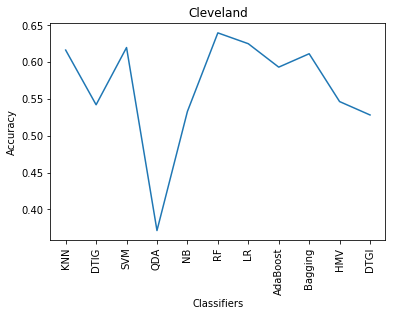

Hepatitis
(array([4.04197455e+00,            nan, 9.93469493e-01,            nan,
       1.37246253e-02, 7.39497592e-03, 6.99553066e-05, 1.03067845e+01,
       1.34431735e+00, 2.56150036e+00, 9.36939142e-01, 1.96901958e+00,
       4.49966555e+00, 2.50099329e-02, 2.41328910e+00, 3.95532591e-01,
       2.95429315e+00, 4.96323499e-02, 1.70744648e+00]), (65, 19))


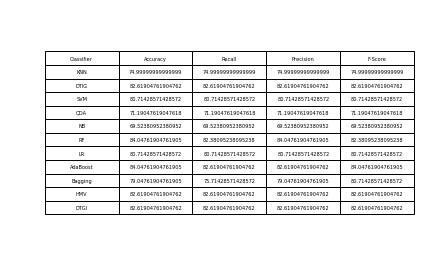

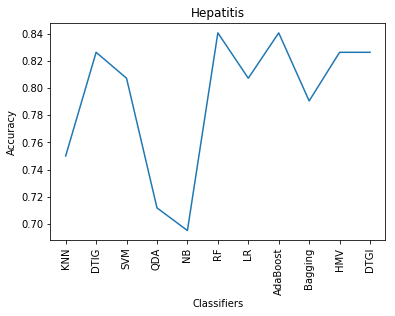

ILPD
(array([13.31852913,         nan,  7.47470204,  8.17516159,  8.19918117,
        7.28950829,  6.21439363,  1.27055996,  6.08910099,  4.73881163]), (288, 10))


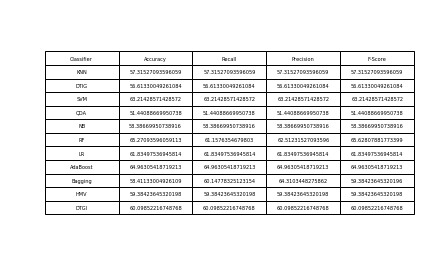

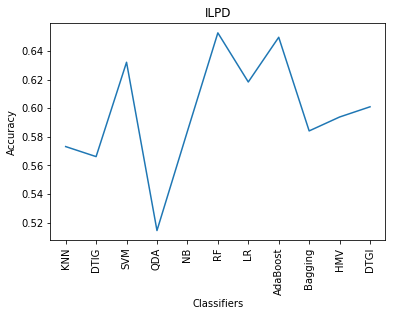

In [699]:
runForAll()